In [3]:
import h5py

file_path = "california/GEDI04_A_2019107224731_O01958_03_T02638_02_002_02_V002.h5"

with h5py.File(file_path, "r") as f:
    # print top-level groups
    print("Top-level keys:", list(f.keys()))

    # example: look at first beam
    beam = list(f.keys())[0]
    print("\nExploring:", beam)
    print("Subkeys:", list(f[beam].keys()))


Top-level keys: ['ANCILLARY', 'BEAM0000', 'BEAM0001', 'BEAM0010', 'BEAM0011', 'BEAM0101', 'BEAM0110', 'BEAM1000', 'BEAM1011', 'METADATA']

Exploring: ANCILLARY
Subkeys: ['model_data', 'pft_lut', 'region_lut']


In [4]:
def walk_h5(obj, indent=0):
    """Recursively print groups/datasets in an HDF5 file."""
    prefix = "  " * indent
    if isinstance(obj, h5py.Group):
        print(f"{prefix}[GROUP] {obj.name}")
        for key in obj.keys():
            walk_h5(obj[key], indent+1)
    elif isinstance(obj, h5py.Dataset):
        print(f"{prefix}[DATASET] {obj.name} shape={obj.shape} dtype={obj.dtype}")

with h5py.File(file_path, "r") as f:
    walk_h5(f)


[GROUP] /
  [GROUP] /ANCILLARY
    [DATASET] /ANCILLARY/model_data shape=(35,) dtype=[('predict_stratum', 'O'), ('model_group', 'u1'), ('model_name', 'O'), ('model_id', 'u1'), ('x_transform', 'O'), ('y_transform', 'O'), ('bias_correction_name', 'O'), ('fit_stratum', 'O'), ('rh_index', 'u1', (8,)), ('predictor_id', 'u1', (8,)), ('predictor_max_value', '<f4', (8,)), ('vcov', '<f8', (5, 5)), ('par', '<f8', (5,)), ('rse', '<f4'), ('dof', '<u4'), ('response_max_value', '<f4'), ('bias_correction_value', '<f4'), ('npar', 'u1')]
    [DATASET] /ANCILLARY/pft_lut shape=(7,) dtype=[('pft_class', 'u1'), ('pft_name', 'O')]
    [DATASET] /ANCILLARY/region_lut shape=(7,) dtype=[('region_class', 'u1'), ('region_name', 'O')]
  [GROUP] /BEAM0000
    [DATASET] /BEAM0000/agbd shape=(142232,) dtype=float32
    [DATASET] /BEAM0000/agbd_pi_lower shape=(142232,) dtype=float32
    [DATASET] /BEAM0000/agbd_pi_upper shape=(142232,) dtype=float32
    [GROUP] /BEAM0000/agbd_prediction
      [DATASET] /BEAM0000/agb

In [5]:
import pandas as pd

# Load FIA
tree = pd.read_csv("USDA_FIA_NFI_CA/CA_TREE.csv")
plot = pd.read_csv("USDA_FIA_NFI_CA/CA_PLOT.csv")

# Step 1: sum tree biomass by plot
biomass_by_plot = tree.groupby("PLT_CN")["DRYBIO_AG"].sum().reset_index()
biomass_by_plot.rename(columns={"DRYBIO_AG": "PLOT_BIOMASS"}, inplace=True)

# Step 2: join with plot table
plot_2021 = plot[plot["MEASYEAR"] == 2021]   # keep only 2021 plots
fia = plot_2021.merge(biomass_by_plot, left_on="CN", right_on="PLT_CN", how="inner")

# Now FIA DataFrame has LAT, LON, and biomass
print(fia[["CN","LAT","LON","PLOT_BIOMASS"]].head())


C:\Users\Masfiq\AppData\Local\Temp\ipykernel_52604\2347477108.py:4: DtypeWarning: Columns (77,157) have mixed types. Specify dtype option on import or set low_memory=False.
  tree = pd.read_csv("USDA_FIA_NFI_CA/CA_TREE.csv")


                CN        LAT         LON   PLOT_BIOMASS
0  750083731290487  36.606596 -121.302037    6612.984572
1  750083915290487  37.438759 -118.979749  255936.033181
2  750083917290487  37.485578 -122.303894   19174.189502
3  750083918290487  37.490313 -121.838419   40164.292519
4  750083926290487  37.512790 -119.901070   15833.917803


In [7]:
import os, re, glob, h5py, numpy as np, pandas as pd, folium
from folium.plugins import FastMarkerCluster
from datetime import datetime, timedelta

# ---------- PATHS (edit) ----------
FIA_TREE_CSV = "USDA_FIA_NFI_CA/CA_TREE.csv"
FIA_PLOT_CSV = "USDA_FIA_NFI_CA/CA_PLOT.csv"
GEDI_DIR     = r"D:\thesis\california"           # folder with many GEDI .h5 files
OUT_HTML     = "fia_gedi_apr2021_map.html"

# ---------- 1) FIA: plot-level biomass for 2021 ----------
tree = pd.read_csv(FIA_TREE_CSV, low_memory=False)
plot = pd.read_csv(FIA_PLOT_CSV, low_memory=False)

# sum tree biomass (kg) per plot
biomass_by_plot = tree.groupby("PLT_CN", as_index=False)["DRYBIO_AG"].sum()
biomass_by_plot.rename(columns={"DRYBIO_AG": "PLOT_BIOMASS_KG"}, inplace=True)

# keep plots measured in 2021 and join
fia2021 = plot.loc[plot["MEASYEAR"] == 2021].merge(
    biomass_by_plot, left_on="CN", right_on="PLT_CN", how="inner"
)

# sanity: drop rows missing coords
lat_col = next(c for c in fia2021.columns if c.upper() == "LAT")
lon_col = next(c for c in fia2021.columns if c.upper() == "LON")
fia2021 = fia2021[np.isfinite(fia2021[lat_col]) & np.isfinite(fia2021[lon_col])].copy()

# ---------- 2) GEDI: read only April 2021 files ----------
# GEDI04_A_<YYYYDOY>_...h5  (YYYY year, DOY day-of-year)
date_pat = re.compile(r"GEDI04_A_(\d{7})")

def yyyydoy_to_date(yyyydoy: str) -> datetime:
    year = int(yyyydoy[:4])
    doy  = int(yyyydoy[4:])
    return datetime(year, 1, 1) + timedelta(doy - 1)

def is_april_2021(fn: str) -> bool:
    m = date_pat.search(os.path.basename(fn))
    if not m: 
        return False
    dt = yyyydoy_to_date(m.group(1))
    return (dt.year == 2021) and (dt.month == 4)

gedi_files = [p for p in glob.glob(os.path.join(GEDI_DIR, "*.h5")) if is_april_2021(p)]
if not gedi_files:
    print("No GEDI files detected for April 2021 in:", GEDI_DIR)

def read_gedi_points(h5_path):
    rows = []
    with h5py.File(h5_path, "r") as f:
        beams = [k for k in f.keys() if k.startswith("BEAM")]
        for bk in beams:
            g = f[bk]
            # lat/lon paths differ across releases; try both
            lat = g.get("lat_lowestmode")
            lon = g.get("lon_lowestmode")
            if lat is None or lon is None:
                if "geolocation" in g:
                    lat = g["geolocation"].get("latitude")
                    lon = g["geolocation"].get("longitude")
            if lat is None or lon is None:
                continue
            lat = np.array(lat[:]); lon = np.array(lon[:])

            # biomass & flags (optional)
            if "agbd" in g:
                agbd = np.array(g["agbd"][:])
            elif "algorithm" in g and "agbd" in g["algorithm"]:
                agbd = np.array(g["algorithm"]["agbd"][:])
            else:
                agbd = np.full_like(lat, np.nan, dtype=float)

            # quality flags if present
            l4q  = g.get("l4_quality_flag")
            agbq = g.get("agbd_quality_flag")
            l4q  = np.array(l4q[:])  if l4q  is not None else np.full_like(lat, np.nan)
            agbq = np.array(agbq[:]) if agbq is not None else np.full_like(lat, np.nan)

            df = pd.DataFrame({
                "file": os.path.basename(h5_path),
                "beam": bk,
                "lat": lat, "lon": lon,
                "agbd": agbd,
                "l4_quality_flag": l4q,
                "agbd_quality_flag": agbq
            })
            rows.append(df)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

gedi_list = [read_gedi_points(p) for p in gedi_files]
gedi = pd.concat(gedi_list, ignore_index=True) if gedi_list else pd.DataFrame(columns=["lat","lon","agbd"])

# quality filtering (keep good if flags exist)
if not gedi.empty:
    mask = np.isfinite(gedi["lat"]) & np.isfinite(gedi["lon"]) & np.isfinite(gedi["agbd"])
    if "l4_quality_flag" in gedi and gedi["l4_quality_flag"].notna().any():
        mask &= (gedi["l4_quality_flag"] == 1)
    if "agbd_quality_flag" in gedi and gedi["agbd_quality_flag"].notna().any():
        mask &= (gedi["agbd_quality_flag"] == 1)
    gedi = gedi.loc[mask].copy()

print(f"FIA plots (2021): {len(fia2021):,}")
print(f"GEDI shots (Apr 2021, after quality filter): {len(gedi):,}")

# ---------- 3) Folium map ----------
# center on FIA if available, else GEDI
if len(fia2021):
    center = [float(fia2021[lat_col].mean()), float(fia2021[lon_col].mean())]
elif len(gedi):
    center = [float(gedi["lat"].mean()), float(gedi["lon"].mean())]
else:
    center = [37.5, -119.5]  # CA fallback

m = folium.Map(location=center, zoom_start=6, tiles="CartoDB positron")

# FIA markers (red) with biomass tooltip
for _, r in fia2021[[lat_col, lon_col, "CN", "PLOT_BIOMASS_KG"]].iterrows():
    folium.CircleMarker(
        location=[float(r[lat_col]), float(r[lon_col])],
        radius=4,
        color="red", fill=True, fill_color="red", fill_opacity=0.85,
        tooltip=f"FIA CN: {int(r['CN'])} | Biomass: {float(r['PLOT_BIOMASS_KG']):,.0f} kg"
    ).add_to(m)

# GEDI shots (blue cluster)
if len(gedi):
    FastMarkerCluster(gedi[["lat","lon"]].values.tolist(), name="GEDI shots (Apr 2021)").add_to(m)

folium.LayerControl().add_to(m)
m.save(OUT_HTML)
print(f"Saved: {OUT_HTML}")


No GEDI files detected for April 2021 in: D:\thesis\california
FIA plots (2021): 749
GEDI shots (Apr 2021, after quality filter): 0
Saved: fia_gedi_apr2021_map.html


In [9]:
import os, glob, h5py, numpy as np, pandas as pd, folium
from folium.plugins import FastMarkerCluster

# ---------- PATHS (edit if needed) ----------
FIA_TREE_CSV = "USDA_FIA_NFI_CA/CA_TREE.csv"
FIA_PLOT_CSV = "USDA_FIA_NFI_CA/CA_PLOT.csv"
GEDI_DIR     = r"D:\thesis\california"     # folder with many GEDI .h5 files
OUT_HTML     = "fia_gedi_allfiles_map.html"

# ---------- 1) FIA: plot-level biomass for 2021 ----------
tree = pd.read_csv(FIA_TREE_CSV, low_memory=False)
plot = pd.read_csv(FIA_PLOT_CSV, low_memory=False)

# Sum tree biomass (kg) per plot CN
biomass_by_plot = tree.groupby("PLT_CN", as_index=False)["DRYBIO_AG"].sum()
biomass_by_plot.rename(columns={"DRYBIO_AG": "PLOT_BIOMASS_KG"}, inplace=True)

# Keep plots measured in 2021 and join with summed biomass
fia2021 = plot.loc[plot["MEASYEAR"] == 2021].merge(
    biomass_by_plot, left_on="CN", right_on="PLT_CN", how="inner"
)

# Clean coordinates
lat_col = next(c for c in fia2021.columns if c.upper() == "LAT")
lon_col = next(c for c in fia2021.columns if c.upper() == "LON")
fia2021 = fia2021[np.isfinite(fia2021[lat_col]) & np.isfinite(fia2021[lon_col])].copy()

print(f"FIA plots (2021): {len(fia2021):,}")

# ---------- 2) GEDI: read ALL .h5 files in folder ----------
gedi_files = sorted(glob.glob(os.path.join(GEDI_DIR, "*.h5")))
if not gedi_files:
    print("No GEDI .h5 files found in:", GEDI_DIR)

def read_gedi_points(h5_path):
    rows = []
    with h5py.File(h5_path, "r") as f:
        beams = [k for k in f.keys() if k.startswith("BEAM")]
        for bk in beams:
            g = f[bk]
            # coordinates can be in different places depending on release
            lat = g.get("lat_lowestmode")
            lon = g.get("lon_lowestmode")
            if lat is None or lon is None:
                if "geolocation" in g:
                    lat = g["geolocation"].get("latitude")
                    lon = g["geolocation"].get("longitude")
            if lat is None or lon is None:
                continue

            lat = np.array(lat[:]); lon = np.array(lon[:])

            # biomass & (optional) quality flags
            if "agbd" in g:
                agbd = np.array(g["agbd"][:])
            elif "algorithm" in g and "agbd" in g["algorithm"]:
                agbd = np.array(g["algorithm"]["agbd"][:])
            else:
                agbd = np.full(lat.shape, np.nan, dtype=float)

            l4q  = g.get("l4_quality_flag")
            agbq = g.get("agbd_quality_flag")
            l4q  = np.array(l4q[:])  if l4q  is not None else np.full(lat.shape, np.nan)
            agbq = np.array(agbq[:]) if agbq is not None else np.full(lat.shape, np.nan)

            df = pd.DataFrame({
                "file": os.path.basename(h5_path),
                "beam": bk,
                "lat": lat, "lon": lon,
                "agbd": agbd,
                "l4_quality_flag": l4q,
                "agbd_quality_flag": agbq
            })
            rows.append(df)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame()

gedi_parts = []
for p in gedi_files:
    try:
        gedi_parts.append(read_gedi_points(p))
    except Exception as e:
        print("Skipping (error):", os.path.basename(p), "|", e)

gedi = pd.concat(gedi_parts, ignore_index=True) if gedi_parts else pd.DataFrame(columns=["lat","lon","agbd"])

# Quality filter (keep good when flags exist)
if not gedi.empty:
    mask = np.isfinite(gedi["lat"]) & np.isfinite(gedi["lon"]) & np.isfinite(gedi["agbd"])
    if "l4_quality_flag" in gedi and gedi["l4_quality_flag"].notna().any():
        mask &= (gedi["l4_quality_flag"] == 1)
    if "agbd_quality_flag" in gedi and gedi["agbd_quality_flag"].notna().any():
        mask &= (gedi["agbd_quality_flag"] == 1)
    gedi = gedi.loc[mask].copy()

print(f"GEDI shots (all files, after quality filter): {len(gedi):,}")

# ---------- 3) Folium map ----------
# center on FIA if available, else GEDI
if len(fia2021):
    center = [float(fia2021[lat_col].mean()), float(fia2021[lon_col].mean())]
elif len(gedi):
    center = [float(gedi['lat'].mean()), float(gedi['lon'].mean())]
else:
    center = [37.5, -119.5]  # California fallback

m = folium.Map(location=center, zoom_start=6, tiles="CartoDB positron")

# FIA markers (red) with biomass tooltip
for _, r in fia2021[[lat_col, lon_col, "CN", "PLOT_BIOMASS_KG"]].iterrows():
    folium.CircleMarker(
        location=[float(r[lat_col]), float(r[lon_col])],
        radius=4, color="red", fill=True, fill_color="red", fill_opacity=0.9,
        tooltip=f"FIA CN: {int(r['CN'])} | Biomass: {float(r['PLOT_BIOMASS_KG']):,.0f} kg"
    ).add_to(m)

# GEDI shots (blue, clustered for speed)
if len(gedi):
    FastMarkerCluster(gedi[["lat","lon"]].values.tolist(), name="GEDI shots (all files)").add_to(m)

folium.LayerControl().add_to(m)
m.save(OUT_HTML)
print(f"Saved: {OUT_HTML}")


FIA plots (2021): 749
GEDI shots (all files, after quality filter): 2,562,963
Saved: fia_gedi_allfiles_map.html


In [10]:
import os, glob, h5py, numpy as np, pandas as pd, folium
from folium.plugins import FastMarkerCluster

# -------- SETTINGS (tweak these if needed) ----------
FIA_TREE_CSV = "USDA_FIA_NFI_CA/CA_TREE.csv"
FIA_PLOT_CSV = "USDA_FIA_NFI_CA/CA_PLOT.csv"
GEDI_DIR     = r"D:\thesis\california"
OUT_HTML     = "fia_gedi_LIGHT.html"

# Keep only FIA plots from this year
FIA_YEAR = 2021

# Clip GEDI to the FIA bounding box with a padding (degrees)
PAD_DEG = 0.5

# Hard cap on points written into HTML (keep it small for speed)
MAX_GEDI_POINTS = 20000   # try 10_000 if you still need smaller

# ----------------------------------------------------

def load_fia_plots(tree_csv, plot_csv, year):
    tree = pd.read_csv(tree_csv, low_memory=False)
    plot = pd.read_csv(plot_csv, low_memory=False)

    # Sum tree biomass per plot
    biomass = tree.groupby("PLT_CN", as_index=False)["DRYBIO_AG"].sum()
    biomass.rename(columns={"DRYBIO_AG": "PLOT_BIOMASS_KG"}, inplace=True)

    # Keep the year you want and join biomass
    fia = plot.loc[plot["MEASYEAR"] == year].merge(
        biomass, left_on="CN", right_on="PLT_CN", how="inner"
    )

    # Clean coords
    lat_col = next(c for c in fia.columns if c.upper() == "LAT")
    lon_col = next(c for c in fia.columns if c.upper() == "LON")
    fia = fia[np.isfinite(fia[lat_col]) & np.isfinite(fia[lon_col])].copy()

    return fia, lat_col, lon_col

def get_bbox(fia, lat_col, lon_col, pad_deg):
    lat_min = float(fia[lat_col].min()) - pad_deg
    lat_max = float(fia[lat_col].max()) + pad_deg
    lon_min = float(fia[lon_col].min()) - pad_deg
    lon_max = float(fia[lon_col].max()) + pad_deg
    return lat_min, lat_max, lon_min, lon_max

def read_gedi_points_filtered(h5_path, bbox):
    """Return a DataFrame of GEDI points INSIDE bbox only."""
    lat_min, lat_max, lon_min, lon_max = bbox
    rows = []
    with h5py.File(h5_path, "r") as f:
        beams = [k for k in f.keys() if k.startswith("BEAM")]
        for bk in beams:
            g = f[bk]
            lat = g.get("lat_lowestmode")
            lon = g.get("lon_lowestmode")
            if lat is None or lon is None:
                if "geolocation" in g:
                    lat = g["geolocation"].get("latitude")
                    lon = g["geolocation"].get("longitude")
            if lat is None or lon is None:
                continue

            lat = np.asarray(lat[:])
            lon = np.asarray(lon[:])

            # bbox filter BEFORE creating DataFrame
            mask = (lat >= lat_min) & (lat <= lat_max) & (lon >= lon_min) & (lon <= lon_max)
            if not mask.any():
                continue

            # biomass (if present)
            if "agbd" in g:
                agbd = np.asarray(g["agbd"][:])[mask]
            elif "algorithm" in g and "agbd" in g["algorithm"]:
                agbd = np.asarray(g["algorithm"]["agbd"][:])[mask]
            else:
                agbd = np.full(mask.sum(), np.nan, dtype=float)

            df = pd.DataFrame({
                "file": os.path.basename(h5_path),
                "beam": bk,
                "lat": lat[mask],
                "lon": lon[mask],
                "agbd": agbd,
            })
            rows.append(df)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["lat","lon","agbd"])

# 1) FIA (year-filtered) + bbox
fia, LAT, LON = load_fia_plots(FIA_TREE_CSV, FIA_PLOT_CSV, FIA_YEAR)
print(f"FIA plots ({FIA_YEAR}): {len(fia):,}")
bbox = get_bbox(fia, LAT, LON, PAD_DEG)

# 2) GEDI: read ALL files, but keep only points inside bbox
gedi_files = sorted(glob.glob(os.path.join(GEDI_DIR, "*.h5")))
if not gedi_files:
    print("No GEDI .h5 files found in:", GEDI_DIR)

gedi_parts = []
for p in gedi_files:
    try:
        gedi_parts.append(read_gedi_points_filtered(p, bbox))
    except Exception as e:
        print("Skipping:", os.path.basename(p), "|", e)

gedi = pd.concat(gedi_parts, ignore_index=True) if gedi_parts else pd.DataFrame(columns=["lat","lon","agbd"])

# Basic clean & decimate
gedi = gedi[np.isfinite(gedi["lat"]) & np.isfinite(gedi["lon"])].copy()
print(f"GEDI shots inside FIA bbox: {len(gedi):,}")

if len(gedi) > MAX_GEDI_POINTS:
    gedi = gedi.sample(MAX_GEDI_POINTS, random_state=0).reset_index(drop=True)
    print(f"Downsampled GEDI to {len(gedi):,} points for a lightweight map.")

# 3) Folium map (lightweight)
center = [float(fia[LAT].mean()), float(fia[LON].mean())]
m = folium.Map(location=center, zoom_start=6, tiles="CartoDB positron")

# FIA markers (red, ~hundreds only)
for _, r in fia[[LAT, LON, "CN", "PLOT_BIOMASS_KG"]].iterrows():
    folium.CircleMarker(
        location=[float(r[LAT]), float(r[LON])],
        radius=4, color="red", fill=True, fill_color="red", fill_opacity=0.9,
        tooltip=f"FIA CN: {int(r['CN'])} | Biomass: {float(r['PLOT_BIOMASS_KG']):,.0f} kg"
    ).add_to(m)

# GEDI markers (blue, clustered, **no tooltips** to keep HTML tiny)
if len(gedi):
    coords = gedi[["lat","lon"]].values.tolist()
    FastMarkerCluster(coords, name="GEDI shots (decimated)").add_to(m)

folium.LayerControl().add_to(m)
m.save(OUT_HTML)
print(f"Saved: {OUT_HTML}  (open in your browser)")


FIA plots (2021): 749
GEDI shots inside FIA bbox: 2,501,551
Downsampled GEDI to 20,000 points for a lightweight map.
Saved: fia_gedi_LIGHT.html  (open in your browser)


In [19]:
import os, glob, h5py, numpy as np, pandas as pd, folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
from shapely.geometry import Point
from sklearn.metrics import r2_score, mean_squared_error
import statsmodels.api as sm

# PATHS 
FIA_TREE_CSV = "USDA_FIA_NFI_CA/CA_TREE.csv"
FIA_PLOT_CSV = "USDA_FIA_NFI_CA/CA_PLOT.csv"
GEDI_DIR     = r"D:\thesis\california"
OUT_MATCHES_CSV = "fia_gedi_matches_2021.csv"
OUT_GEDI_CAL_CSV = "gedi_all_calibrated.csv"
OUT_HTML     = "fia_gedi_calibrated_map.html"

# SETTINGS 
FIA_YEAR = 2021
MAX_MATCH_DIST_M = 50      # nearest GEDI shot within 50 m
PLOT_AREA_HA = 0.0673      # FIA Phase-2 plot area (~4 subplots radius 7.32 m) => ~0.0673 ha
SAMPLE_GEDI_FOR_MAP = 15000  # to keep HTML light; reduce if needed

#  1) Build FIA plot biomass for 2021 (Mg/ha) 
tree = pd.read_csv(FIA_TREE_CSV, low_memory=False)
plot = pd.read_csv(FIA_PLOT_CSV, low_memory=False)

# Sum tree biomass per plot (kg)
biomass_by_plot = tree.groupby("PLT_CN", as_index=False)["DRYBIO_AG"].sum()
biomass_by_plot.rename(columns={"DRYBIO_AG": "PLOT_BIOMASS_KG"}, inplace=True)

# Keep 2021 plots; join lat/lon + biomass
fia2021 = plot.loc[plot["MEASYEAR"] == FIA_YEAR].merge(
    biomass_by_plot, left_on="CN", right_on="PLT_CN", how="inner"
)

# Clean coordinates
lat_col = next(c for c in fia2021.columns if c.upper() == "LAT")
lon_col = next(c for c in fia2021.columns if c.upper() == "LON")
fia2021 = fia2021[np.isfinite(fia2021[lat_col]) & np.isfinite(fia2021[lon_col])].copy()

# Convert to Mg/ha
fia2021["FIA_MGHA"] = (fia2021["PLOT_BIOMASS_KG"] / 1000.0) / PLOT_AREA_HA

print(f"FIA plots (2021) with biomass: {len(fia2021):,}")

# Read ALL GEDI L4A files -> lat/lon/agbd (+flags) 
def read_gedi_points(h5_path):
    rows = []
    with h5py.File(h5_path, "r") as f:
        beams = [k for k in f.keys() if k.startswith("BEAM")]
        for bk in beams:
            g = f[bk]
            lat = g.get("lat_lowestmode")
            lon = g.get("lon_lowestmode")
            if lat is None or lon is None:
                if "geolocation" in g:
                    lat = g["geolocation"].get("latitude")
                    lon = g["geolocation"].get("longitude")
            if lat is None or lon is None:
                continue
            lat = np.asarray(lat[:]); lon = np.asarray(lon[:])

            # biomass
            if "agbd" in g:
                agbd = np.asarray(g["agbd"][:])
            elif "algorithm" in g and "agbd" in g["algorithm"]:
                agbd = np.asarray(g["algorithm"]["agbd"][:])
            else:
                agbd = np.full(lat.shape, np.nan, dtype=float)

            # quality flags (optional)
            l4q  = g.get("l4_quality_flag"); l4q  = np.asarray(l4q[:])  if l4q  is not None else np.full(lat.shape, np.nan)
            agbq = g.get("agbd_quality_flag"); agbq = np.asarray(agbq[:]) if agbq is not None else np.full(lat.shape, np.nan)

            df = pd.DataFrame({
                "file": os.path.basename(h5_path),
                "beam": bk,
                "lat": lat, "lon": lon,
                "agbd": agbd,
                "l4_quality_flag": l4q,
                "agbd_quality_flag": agbq
            })
            rows.append(df)
    return pd.concat(rows, ignore_index=True) if rows else pd.DataFrame(columns=["lat","lon","agbd"])

gedi_files = sorted(glob.glob(os.path.join(GEDI_DIR, "*.h5")))
if not gedi_files:
    raise FileNotFoundError(f"No GEDI .h5 files found in {GEDI_DIR}")

gedi_parts = []
for p in gedi_files:
    try:
        gedi_parts.append(read_gedi_points(p))
    except Exception as e:
        print("Skipping (error):", os.path.basename(p), "|", e)

gedi = pd.concat(gedi_parts, ignore_index=True)
# basic quality screen
mask = np.isfinite(gedi["lat"]) & np.isfinite(gedi["lon"]) & np.isfinite(gedi["agbd"])
if "l4_quality_flag" in gedi and gedi["l4_quality_flag"].notna().any():
    mask &= (gedi["l4_quality_flag"] == 1)
if "agbd_quality_flag" in gedi and gedi["agbd_quality_flag"].notna().any():
    mask &= (gedi["agbd_quality_flag"] == 1)
gedi = gedi.loc[mask].copy()

print(f"GEDI shots (after quality filter): {len(gedi):,}")

# Nearest-neighbor match: FIA (2021) -> GEDI (≤ MAX_MATCH_DIST_M) 
# Use a projected CRS for meter distances. EPSG:5070 = NAD83 / Conus Albers
# fia_gdf = gpd.GeoDataFrame(
#     fia2021.copy(),
#     geometry=gpd.points_from_xy(fia2021[lon_col], fia2021[lat_col]),
#     crs="EPSG:4326"
# ).to_crs(5070)

# gedi_gdf = gpd.GeoDataFrame(
#     gedi.copy(),
#     geometry=gpd.points_from_xy(gedi["lon"], gedi["lat"]),
#     crs="EPSG:4326"
# ).to_crs(5070)

# matches = gpd.sjoin_nearest(
#     fia_gdf, gedi_gdf,
#     how="left", distance_col="dist_m", max_distance=MAX_MATCH_DIST_M
# )

# matched = matches["dist_m"].notna().sum()
# print(f"Matched {matched}/{len(fia_gdf)} FIA plots within {MAX_MATCH_DIST_M} m")

# # Keep only matched rows and gather needed cols
# cols = {
#     "CN": "FIA_CN",
#     lat_col: "FIA_LAT",
#     lon_col: "FIA_LON",
#     "FIA_MGHA": "FIA_MGHA",
#     "agbd": "GEDI_AGBD",
#     "dist_m": "dist_m"
# }
# keep = list(cols.keys())
# matched_df = matches[keep].rename(columns=cols).dropna(subset=["GEDI_AGBD"]).copy()
# matched_df.to_csv(OUT_MATCHES_CSV, index=False)
# print(f"Saved matches → {OUT_MATCHES_CSV}  (rows: {len(matched_df)})")


    # ---------- Replace Section 3 (and part of 4) with this ----------

MATCH_R = 150  # meters (try 100–200 if needed)

# 3a) relax GEDI quality: require only l4_quality_flag==1 if present
mask = np.isfinite(gedi["lat"]) & np.isfinite(gedi["lon"]) & np.isfinite(gedi["agbd"])
if "l4_quality_flag" in gedi and gedi["l4_quality_flag"].notna().any():
    mask &= (gedi["l4_quality_flag"] == 1)
gedi = gedi.loc[mask].copy()

# 3b) project to meters
fia_gdf = gpd.GeoDataFrame(
    fia2021.copy(),
    geometry=gpd.points_from_xy(fia2021[lon_col], fia2021[lat_col]),
    crs="EPSG:4326"
).to_crs(5070)

gedi_gdf = gpd.GeoDataFrame(
    gedi.copy(),
    geometry=gpd.points_from_xy(gedi["lon"], gedi["lat"]),
    crs="EPSG:4326"
).to_crs(5070)

# 3c) radius join: pick all GEDI shots within MATCH_R of each FIA plot
buffered = fia_gdf[["CN","FIA_MGHA","geometry"]].copy()
buffered["geometry"] = buffered.buffer(MATCH_R)

# spatial join (GEDI inside buffered polygons)
joined = gpd.sjoin(gedi_gdf[["agbd","geometry"]], buffered, how="inner", predicate="within")

# distance diagnostics (center-to-shot)
# Create a GeoSeries of FIA point geometries keyed by CN
fia_center = fia_gdf.set_index("CN").geometry

# Map each joined row's CN to its FIA point geometry, and cast to GeoSeries (same CRS)
joined["fia_geom"] = joined["CN"].map(fia_center)
joined["fia_geom"] = gpd.GeoSeries(joined["fia_geom"], crs=fia_gdf.crs)

# Now distances: GeoSeries ↔ GeoSeries (index-aligned)
joined["dist_m"] = joined.geometry.distance(joined["fia_geom"])

print(f"FIA plots: {len(fia_gdf):,} | GEDI shots: {len(gedi_gdf):,}")
print(f"FIA plots with ≥1 GEDI shot within {MATCH_R} m: {joined['CN'].nunique():,}")
if len(joined):
    print(joined["dist_m"].describe())

# 3d) aggregate GEDI to plot: mean AGBD (you can also take median)
plot_agg = (joined
            .groupby("CN", as_index=False)
            .agg(GEDI_AGBD_mean=("agbd","mean"),
                 GEDI_hits=("agbd","size"),
                 GEDI_dist_mean=("dist_m","mean")))

matched_df = fia_gdf.merge(plot_agg, on="CN", how="inner")
matched_df = matched_df.rename(columns={lat_col: "FIA_LAT", lon_col: "FIA_LON"})
matched_df = matched_df[["CN","FIA_LAT","FIA_LON","FIA_MGHA","GEDI_AGBD_mean","GEDI_hits","GEDI_dist_mean"]].copy()
matched_df.to_csv(OUT_MATCHES_CSV, index=False)
print(f"Saved matches → {OUT_MATCHES_CSV}  (rows: {len(matched_df)})")

# Calibrate if we have enough matches 
MIN_N = 30
if len(matched_df) < MIN_N:
    print(f"Only {len(matched_df)} matched plots — increase MATCH_R (e.g., 200 m) "
          f"or include more GEDI files/time to reach ≥{MIN_N} for a stable fit.")
else:
    X = sm.add_constant(matched_df["GEDI_AGBD_mean"].values)
    y = matched_df["FIA_MGHA"].values
    rlm = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()
    slope = float(rlm.params[1]); intercept = float(rlm.params[0])

    pred = rlm.predict(X)
    r2 = r2_score(y, pred)

    # older sklearn: no 'squared' kwarg
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)

    print(f"Calibration: FIA_MGHA ≈ {intercept:.2f} + {slope:.2f} * GEDI_agbd_mean")
    print(f"R² = {r2:.3f} | RMSE = {rmse:.2f} Mg/ha | n = {len(y)}")

    # Apply to ALL GEDI shots
    gedi["Calibrated_MGHA"] = intercept + slope * gedi["agbd"].astype(float)
    gedi_out = gedi[["lat","lon","agbd","Calibrated_MGHA"]].copy()
    gedi_out.to_csv(OUT_GEDI_CAL_CSV, index=False)
    print(f"Saved calibrated GEDI → {OUT_GEDI_CAL_CSV}  (rows: {len(gedi_out)})")


#  Calibrate GEDI AGBD to FIA MG/ha (robust linear fit)
MIN_N = 30
# keep only rows that have both FIA and GEDI means
calib = matched_df.dropna(subset=["FIA_MGHA", "GEDI_AGBD_mean"]).copy()

if len(calib) < MIN_N:
    print(f"Only {len(calib)} matched plots — try a larger MATCH_R (e.g., 200 m) "
          f"or relax quality filters.")
else:
    # X = [1, GEDI mean agbd], y = FIA Mg/ha
    X = sm.add_constant(calib["GEDI_AGBD_mean"].astype(float).values)
    y = calib["FIA_MGHA"].astype(float).values

    rlm = sm.RLM(y, X, M=sm.robust.norms.HuberT()).fit()
    intercept, slope = float(rlm.params[0]), float(rlm.params[1])

    pred = rlm.predict(X)
    r2 = r2_score(y, pred)
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)

    print(f"Calibration: FIA_MGHA ≈ {intercept:.2f} + {slope:.2f} * GEDI_agbd_mean")
    print(f"R² = {r2:.3f} | RMSE = {rmse:.2f} Mg/ha | n = {len(y)}")

    # Apply to ALL GEDI shots
    gedi["Calibrated_MGHA"] = intercept + slope * gedi["agbd"].astype(float)
    gedi_out = gedi[["lat","lon","agbd","Calibrated_MGHA"]].copy()
    gedi_out.to_csv(OUT_GEDI_CAL_CSV, index=False)
    print(f"Saved calibrated GEDI → {OUT_GEDI_CAL_CSV}  (rows: {len(gedi_out)})")


# Apply calibration to ALL GEDI shots
gedi["Calibrated_MGHA"] = intercept + slope * gedi["agbd"].astype(float)
gedi_out = gedi[["lat","lon","agbd","Calibrated_MGHA"]].copy()
gedi_out.to_csv(OUT_GEDI_CAL_CSV, index=False)
print(f"Saved calibrated GEDI → {OUT_GEDI_CAL_CSV}  (rows: {len(gedi_out)})")

#  Lightweight Folium map 
center = [float(fia2021[lat_col].mean()), float(fia2021[lon_col].mean())]
m = folium.Map(location=center, zoom_start=6, tiles="CartoDB positron")

# FIA plots (red)
for _, r in fia2021[[lat_col, lon_col, "CN", "FIA_MGHA"]].iterrows():
    folium.CircleMarker(
        location=[float(r[lat_col]), float(r[lon_col])],
        radius=4, color="red", fill=True, fill_color="red", fill_opacity=0.9,
        tooltip=f"FIA CN: {int(r['CN'])} | {float(r['FIA_MGHA']):.1f} Mg/ha"
    ).add_to(m)

# GEDI calibrated biomass — sample & color by value (keep it light)
if len(gedi_out):
    sample = gedi_out.sample(min(SAMPLE_GEDI_FOR_MAP, len(gedi_out)), random_state=0)
    vmin, vmax = float(sample["Calibrated_MGHA"].quantile(0.05)), float(sample["Calibrated_MGHA"].quantile(0.95))
    # simple 5-bin coloring to avoid heavy HTML
    bins = np.linspace(vmin, vmax, 6)
    colors = ["#2c7bb6","#abd9e9","#ffffbf","#fdae61","#d7191c"]

    def color_for(x):
        idx = np.digitize(x, bins) - 1
        idx = max(0, min(idx, len(colors)-1))
        return colors[idx]

    for _, r in sample.iterrows():
        val = float(r["Calibrated_MGHA"])
        folium.CircleMarker(
            location=[float(r["lat"]), float(r["lon"])],
            radius=3, color=None, fill=True, fill_color=color_for(val), fill_opacity=0.7
        ).add_to(m)

    # add cluster layer (counts only) for the full set, but lightweight
    FastMarkerCluster(gedi_out[["lat","lon"]].values.tolist(), name="GEDI shots (counts)", showCoverageOnHover=False).add_to(m)

folium.LayerControl().add_to(m)
m.save(OUT_HTML)
print(f"Saved map → {OUT_HTML}")


FIA plots (2021) with biomass: 749
GEDI shots (after quality filter): 2,562,963
FIA plots: 749 | GEDI shots: 2,562,963
FIA plots with ≥1 GEDI shot within 150 m: 32
count    106.000000
mean     100.882401
std       34.165580
min       22.196315
25%       78.637887
50%      104.548368
75%      132.125168
max      149.121548
Name: dist_m, dtype: float64
Saved matches → fia_gedi_matches_2021.csv  (rows: 32)
Calibration: FIA_MGHA ≈ 945.30 + 0.76 * GEDI_agbd_mean
R² = -0.024 | RMSE = 1714.79 Mg/ha | n = 32
Saved calibrated GEDI → gedi_all_calibrated.csv  (rows: 2562963)
Calibration: FIA_MGHA ≈ 945.30 + 0.76 * GEDI_agbd_mean
R² = -0.024 | RMSE = 1714.79 Mg/ha | n = 32
Saved calibrated GEDI → gedi_all_calibrated.csv  (rows: 2562963)
Saved calibrated GEDI → gedi_all_calibrated.csv  (rows: 2562963)
Saved map → fia_gedi_calibrated_map.html


C:\Users\Masfiq\AppData\Local\Temp\ipykernel_52604\2259798579.py:6: DtypeWarning: Columns (77,157) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("USDA_FIA_NFI_CA/CA_TREE.csv").groupby("PLT_CN")["DRYBIO_AG"].sum().reset_index(),


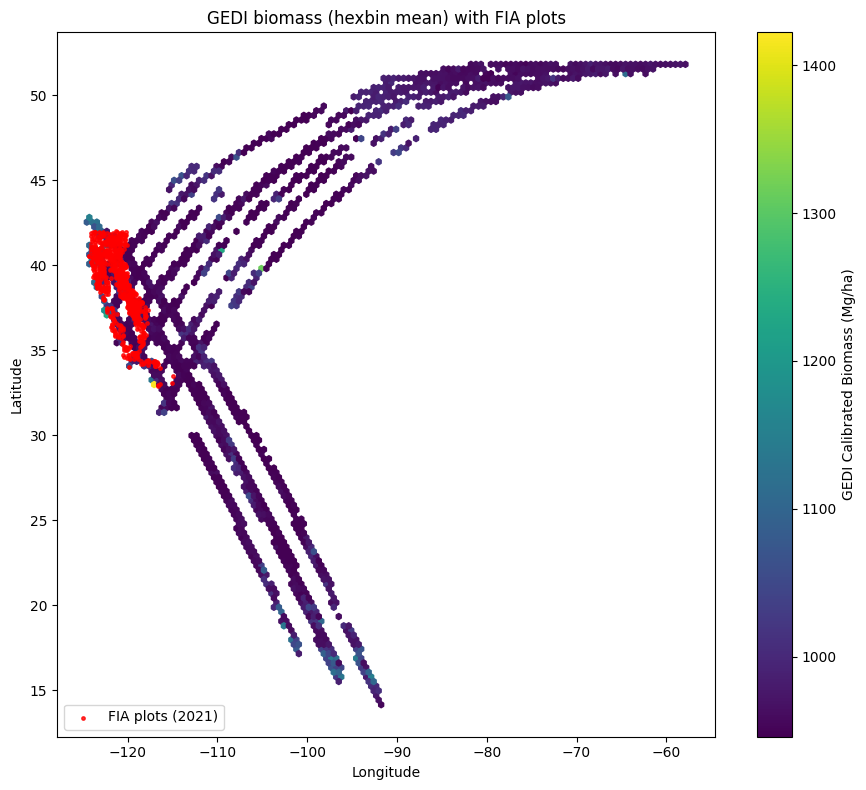

In [20]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# 1) Load what you already saved
gedi = pd.read_csv("gedi_all_calibrated.csv")        # columns: lat, lon, agbd, Calibrated_MGHA
fia  = pd.read_csv("USDA_FIA_NFI_CA/CA_PLOT.csv").merge(
        pd.read_csv("USDA_FIA_NFI_CA/CA_TREE.csv").groupby("PLT_CN")["DRYBIO_AG"].sum().reset_index(),
        left_on="CN", right_on="PLT_CN", how="inner"
      )
fia = fia[fia["MEASYEAR"]==2021].dropna(subset=["LAT","LON"]).copy()
fia["FIA_MGHA"] = (fia["DRYBIO_AG"]/1000.0) / 0.0673

# 2) Downselect GEDI to California box (optional) or use all
mask = np.isfinite(gedi["lon"]) & np.isfinite(gedi["lat"]) & np.isfinite(gedi["Calibrated_MGHA"])
g = gedi.loc[mask, ["lon","lat","Calibrated_MGHA"]].copy()

# 3) Hexbin = mean calibrated biomass per hex
plt.figure(figsize=(9,8))
hb = plt.hexbin(
    g["lon"].values, g["lat"].values,
    C=g["Calibrated_MGHA"].values,
    gridsize=120, reduce_C_function=np.mean, mincnt=5
)
plt.colorbar(hb, label="GEDI Calibrated Biomass (Mg/ha)")
plt.scatter(fia["LON"], fia["LAT"], s=6, c="red", alpha=0.8, label="FIA plots (2021)")
plt.xlabel("Longitude"); plt.ylabel("Latitude")
plt.title("GEDI biomass (hexbin mean) with FIA plots")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()


In [22]:
import pandas as pd, hvplot.pandas  # noqa
import holoviews as hv
import datashader as ds
from holoviews.operation.datashader import datashade, rasterize
hv.extension('bokeh')

gedi = pd.read_csv("gedi_all_calibrated.csv")
fia  = pd.read_csv("USDA_FIA_NFI_CA/CA_PLOT.csv").merge(
        pd.read_csv("USDA_FIA_NFI_CA/CA_TREE.csv").groupby("PLT_CN")["DRYBIO_AG"].sum().reset_index(),
        left_on="CN", right_on="PLT_CN", how="inner"
      )
fia = fia[fia["MEASYEAR"]==2021].dropna(subset=["LAT","LON"]).copy()
fia["FIA_MGHA"] = (fia["DRYBIO_AG"]/1000.0) / 0.0673

# GEDI: color by mean biomass in each pixel while zooming
points = gedi[['lon','lat','Calibrated_MGHA']].dropna()
gedi_plot = rasterize(
    hv.Points(points, kdims=['lon','lat'], vdims=['Calibrated_MGHA']),
    aggregator=ds.mean('Calibrated_MGHA'),
    width=800, height=650
).opts(colorbar=True, cmap='Viridis', clim=(points['Calibrated_MGHA'].quantile(0.05),
                                            points['Calibrated_MGHA'].quantile(0.95)),
       tools=['hover','wheel_zoom','pan','reset'], active_tools=['wheel_zoom'])

# FIA points (red) as an overlay (decimate to keep it smooth)
fia_small = fia.sample(min(2000, len(fia)), random_state=0)
fia_plot = hv.Points(fia_small, kdims=['LON','LAT']).opts(color='red', size=4, alpha=0.8)

(gedi_plot * fia_plot)


C:\Users\Masfiq\AppData\Local\Temp\ipykernel_52604\339180441.py:9: DtypeWarning: Columns (77,157) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("USDA_FIA_NFI_CA/CA_TREE.csv").groupby("PLT_CN")["DRYBIO_AG"].sum().reset_index(),


:DynamicMap   []
   :Overlay
      .Image.I  :Image   [lon,lat]   (lon_lat Calibrated_MGHA)
      .Points.I :Points   [LON,LAT]   (CN,SRV_CN,CTY_CN,PREV_PLT_CN,INVYR,STATECD,UNITCD,COUNTYCD,PLOT,PLOT_STATUS_CD,PLOT_NONSAMPLE_REASN_CD,MEASYEAR,MEASMON,MEASDAY,REMPER,KINDCD,DESIGNCD,RDDISTCD,WATERCD,ELEV,GROW_TYP_CD,MORT_TYP_CD,P2PANEL,P3PANEL,MANUAL,KINDCD_NC,QA_STATUS,CREATED_DATE,MODIFIED_DATE,MICROPLOT_LOC,DECLINATION,SAMP_METHOD_CD,SUBP_EXAMINE_CD,MACRO_BREAKPOINT_DIA,INTENSITY,CYCLE,SUBCYCLE,TOPO_POSITION_PNW,NF_SAMPLING_STATUS_CD,NF_PLOT_STATUS_CD,NF_PLOT_NONSAMPLE_REASN_CD,P2VEG_SAMPLING_STATUS_CD,P2VEG_SAMPLING_LEVEL_DETAIL_CD,INVASIVE_SAMPLING_STATUS_CD,INVASIVE_SPECIMEN_RULE_CD,DESIGNCD_P2A,MANUAL_DB,SUBPANEL,FUTFORCD_RMRS,MANUAL_NCRS,MANUAL_NERS,MANUAL_RMRS,PAC_ISLAND_PNWRS,PLOT_SEASON_NERS,PREV_MICROPLOT_LOC_RMRS,PREV_PLOT_STATUS_CD_RMRS,REUSECD1,REUSECD2,REUSECD3,GRND_LYR_SAMPLING_STATUS_CD,GRND_LYR_SAMPLING_METHOD_CD,PLT_CN,DRYBIO_AG,FIA_MGHA)